In [185]:
#!wmic cpu get NumberOfCores,NumberOfLogicalProcessors

In [186]:
import os
os.environ['OMP_NUM_THREADS']='7'

In [187]:
# import the necessary libraries

import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import set_config             
set_config(transform_output="pandas")      
import multiprocessing
from sklearn.ensemble import RandomForestClassifier

In [188]:
# to load dataframe

url = 'https://drive.google.com/file/d/1egIe9oo7_GHU61AzqiHoWC-SsMrhE9oG/view?usp=sharing'
path = 'https://drive.google.com/uc?id='+url.split('/')[-2]
df_states = pd.read_csv(path)

In [189]:
display(df_states.info())
display(df_states.columns)
display(df_states.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2652 entries, 0 to 2651
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           2652 non-null   int64  
 1   month          2652 non-null   int64  
 2   state          2652 non-null   object 
 3   fire qty       2652 non-null   int64  
 4   hectares       2652 non-null   float64
 5   temperature    2652 non-null   float64
 6   precipitation  2635 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 145.2+ KB


None

Index(['year', 'month', 'state', 'fire qty', 'hectares', 'temperature',
       'precipitation'],
      dtype='object')

,year,month,state,fire qty,hectares,temperature,precipitation
0,2010,1,Baden Wurttemberg,0,0.0,-2.76,NaN


In [190]:
df_states.rename(columns={'fire qty':'fires_qty', 'hectares': 'burned_ha'}, inplace=True)
df_states = df_states[['state', 'year', 'month', 'fires_qty', 'burned_ha', 'temperature', 'precipitation']]

In [191]:
# we'll remove 'Germany' rows since this is a 'state' approach
# df_states = df_states.query('state != "Germany"')
# df_states.info()

# We'll start by labeling the dataset - 0, 1, 2 for low, medium, high fire risk with an unsupervised machine learning model

In [192]:
# first we need to scale - we'll use the standard scaler

# features we want to scale - we're basing our clustering on the burned area
to_scale = ["fires_qty", "burned_ha"]

# Rather than alter my original dataframe, I will make a copy
scaled_fires = df_states.copy()

# Now I take the columns I wish to scale, fit and transform them, and inject them back into my dataframe
scaled_fires[to_scale] = StandardScaler().fit_transform(df_states[to_scale])
scaled_fires.head(1)

,state,year,month,fires_qty,burned_ha,temperature,precipitation
0,Baden Wurttemberg,2010,1,-0.265752,-0.116225,-2.76,NaN


In [193]:
scaled_fires.iloc[:, 3:5]

,fires_qty,burned_ha
0,-0.265752,-0.116225
1,-0.265752,-0.116225
2,-0.184131,-0.105429
3,-0.075302,-0.058196
4,-0.265752,-0.116225
...,...,...
2647,15.922534,4.620594
2648,4.631544,0.747468
2649,1.094608,0.059213
2650,0.904157,0.099698


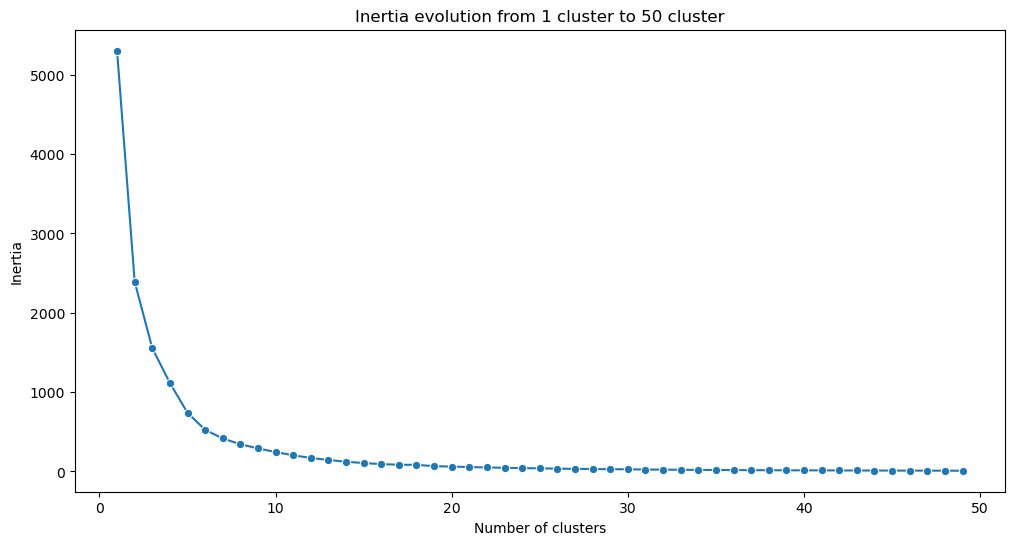

In [194]:
# we can make an elbow plot to find the best number of clusters

from sklearn.cluster import KMeans

max_k = 50
inertia = []

for k in range(1, max_k):
    inertia.append(KMeans(n_clusters=k, random_state = 444).fit(scaled_fires.iloc[:, 3:5]).inertia_) # we use iloc to select only the numeric columns of the data frame
                                                                                                     
fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia evolution from 1 cluster to {max_k} cluster')
sns.lineplot(x=range(1, max_k), y=inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

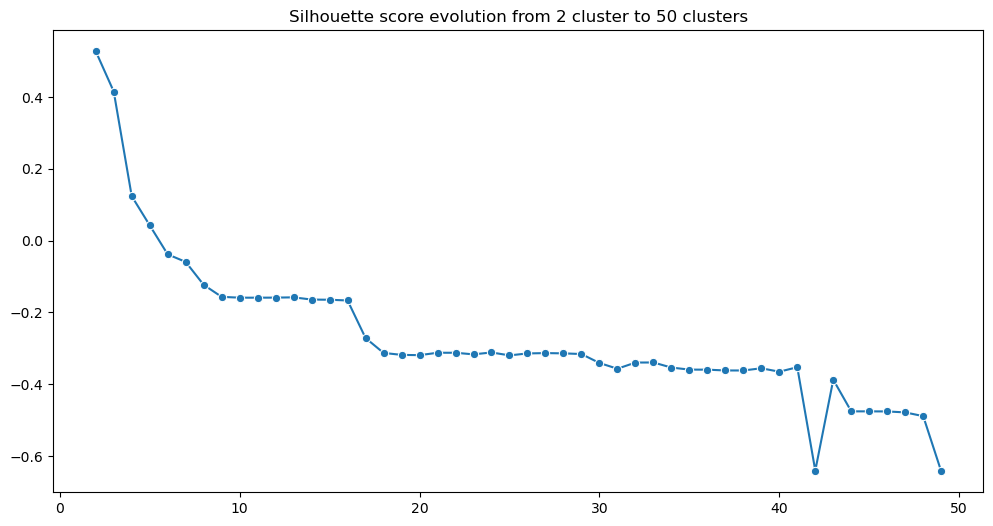

In [195]:
# and a silhouette plot

# to check the silhouette score with KMeans - supposedly, the best number of clusters to chose would be represented by the point that's closer to one

from sklearn.metrics import silhouette_score

max_k = 50
sil_score = []

for k in range(2, max_k):
    labels = KMeans(n_clusters=k, random_state = 444).fit(scaled_fires.iloc[:, 3:5]).labels_ # same as before, we use iloc to select only the numeric columns
    sil_score.append(silhouette_score(scaled_fires.iloc[:, 2:4], labels))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Silhouette score evolution from 2 cluster to {max_k} clusters')
sns.lineplot(x=range(2, max_k), y=sil_score, marker='o')
plt.show()

With the plots we can conclude that 2-3 clusters is a good choice, so we'll continue with the plan of having 3 clusters

In [196]:
# we'll create the labels with Kmeans

kmeans = KMeans(n_clusters = 3, n_init = "auto", random_state = 444) # we choose a random state for reproducibility
kmeans.fit(scaled_fires.iloc[:, 3:5])

KMeans(n_clusters=3, n_init='auto', random_state=444)

In [197]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [198]:
labeled_fires =  df_states.copy()
labeled_fires["cluster"] = kmeans.labels_
labeled_fires.head(1)

,state,year,month,fires_qty,burned_ha,temperature,precipitation,cluster
0,Baden Wurttemberg,2010,1,0,0.0,-2.76,NaN,0


In [199]:
labeled_fires.groupby('cluster').count()

,state,year,month,fires_qty,burned_ha,temperature,precipitation
cluster,,,,,,,
0,2610,2610,2610,2610,2610,2610,2593
1,5,5,5,5,5,5,5
2,37,37,37,37,37,37,37


In [200]:
labeled_fires.burned_ha.value_counts()

burned_ha
0.00     1856
1.00      212
2.00       90
3.00       46
4.00       40
         ... 
1.33        1
0.86        1
3.13        1
4.35        1
64.00       1
Name: count, Length: 147, dtype: int64

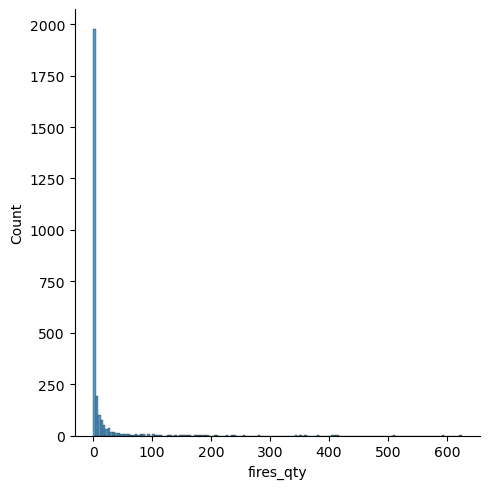

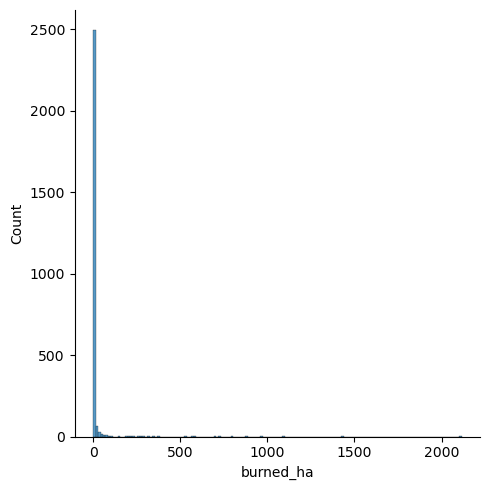

In [201]:
sns.displot(df_states, x="fires_qty", bins = 150);
sns.displot(df_states, x="burned_ha", bins = 150);

In [202]:
# we'll use a log-10 transformation to expand the data
# since the records are monthly, there are months with zero fires
# in order to use the log-10 function we need to give them a value over 0

import math
labeled_fires['log_fires'] = labeled_fires['fires_qty'].apply(lambda x: math.log10(x) if x > 0 else 0.00000000001)
labeled_fires['log_burned'] = labeled_fires['burned_ha'].apply(lambda x: math.log10(x) if x > 0 else 0.00000000001)

In [203]:
# the columns with the log_values have been created, so now we can re-categorize the data
labeled_fires.head(1)

,state,year,month,fires_qty,burned_ha,temperature,precipitation,cluster,log_fires,log_burned
0,Baden Wurttemberg,2010,1,0,0.0,-2.76,NaN,0,1.000000e-11,1.000000e-11


In [204]:
# first we need to scale - we'll use the standard scaler

# features we want to scale - we're basing our clustering on the burned area
to_scale = ["log_fires", "log_burned"]

# Rather than alter my original dataframe, I will make a copy
scaled_fires = labeled_fires.copy()

# Now I take the columns I wish to scale, fit and transform them, and inject them back into my dataframe
scaled_fires[to_scale] = StandardScaler().fit_transform(labeled_fires[to_scale])
scaled_fires.head(1)

,state,year,month,fires_qty,burned_ha,temperature,precipitation,cluster,log_fires,log_burned
0,Baden Wurttemberg,2010,1,0,0.0,-2.76,NaN,0,-0.648402,-0.350751


In [205]:
scaled_fires.iloc[:, 8:10]

,log_fires,log_burned
0,-0.648402,-0.350751
1,-0.648402,-0.350751
2,0.168519,-0.547930
3,0.798564,0.938137
4,-0.648402,-0.350751
...,...,...
2647,4.102090,4.828065
2648,3.213046,3.324198
2649,2.260553,1.915737
2650,2.148402,2.099215


In [206]:
# we'll create new labels with Kmeans

kmeans_num = KMeans(n_clusters = 3, n_init = "auto", random_state = 100) # we choose a random state for reproducibility
kmeans_num.fit(scaled_fires.iloc[:, 8:10])

KMeans(n_clusters=3, n_init='auto', random_state=100)

In [207]:
labeled_fires["cluster"] = kmeans_num.labels_
labeled_fires.head(1)

,state,year,month,fires_qty,burned_ha,temperature,precipitation,cluster,log_fires,log_burned
0,Baden Wurttemberg,2010,1,0,0.0,-2.76,NaN,0,1.000000e-11,1.000000e-11


In [208]:
labeled_fires.groupby('cluster').count()

,state,year,month,fires_qty,burned_ha,temperature,precipitation,log_fires,log_burned
cluster,,,,,,,,,
0,1880,1880,1880,1880,1880,1880,1863,1880,1880
1,249,249,249,249,249,249,249,249,249
2,523,523,523,523,523,523,523,523,523


In [209]:
labeled_fires.groupby('cluster')[['fires_qty', 'burned_ha']].mean()

,fires_qty,burned_ha
cluster,,
0,0.479255,0.071032
1,77.947791,86.646466
2,10.695985,2.163212


In [210]:
labeled_fires.groupby('cluster')[['fires_qty', 'burned_ha']].sum()

,fires_qty,burned_ha
cluster,,
0,901,133.54
1,19409,21574.97
2,5594,1131.36


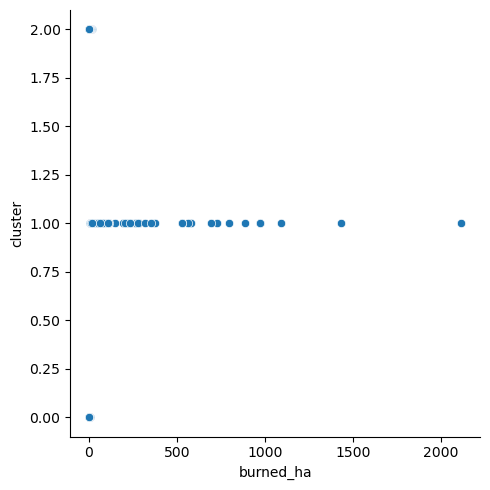

In [211]:
sns.relplot(data=labeled_fires, x="burned_ha", y="cluster");

# Now we build the Supervised Machine Learning Model
Since we have imbalanced data we may want to use SVM or Random Forest

In [212]:
labeled_fires.columns

Index(['state', 'year', 'month', 'fires_qty', 'burned_ha', 'temperature',
       'precipitation', 'cluster', 'log_fires', 'log_burned'],
      dtype='object')

In [213]:
# we need to create a new data frame with only the columns we'll use for the model

model_states_df = labeled_fires[['state', 'year', 'month', 'temperature', 'precipitation', 'cluster']]
model_states_df

,state,year,month,temperature,precipitation,cluster
0,Baden Wurttemberg,2010,1,-2.76,NaN,0
1,Baden Wurttemberg,2010,2,0.13,60.2,0
2,Baden Wurttemberg,2010,3,3.81,51.5,0
3,Baden Wurttemberg,2010,4,8.79,23.8,2
4,Baden Wurttemberg,2010,5,10.65,129.9,0
...,...,...,...,...,...,...
2647,Germany,2022,8,20.23,48.9,1
2648,Germany,2022,9,13.37,100.0,1
2649,Germany,2022,10,12.52,49.7,1
2650,Germany,2022,11,6.35,48.9,1


In [214]:
# we don't need germany, so we'll exclude it from the analysis
# model_states_df = model_states_df.query('state !=  "Germany"')

In [215]:
# now we need to split our dataset into X and y  - X will be the features we'll use for the model and y will be the target

X = model_states_df
y = X.pop('cluster') # we'll use the cluster column as our target

In [216]:
# and now we can split into traing and testing sets
# 80% for training and 20% for testing  - we'll use the random_state parameter to make sure we get the same split every time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [217]:
# first we need to divide into numerical and categorical data

X_num_train =  X_train.select_dtypes(include = "number")
X_num_test = X_test.select_dtypes(include = "number")
X_cat_train = X_train.select_dtypes(exclude="number")
X_cat_test = X_test.select_dtypes(exclude="number")

In [218]:
# now we need to impute the missing values in the dataset  - we'll use the SimpleImputer class from the sklearn library

# we import necessary libraries
from sklearn.impute import SimpleImputer

# we start with numeric features
num_imputer = SimpleImputer(strategy = 'mean')                 # first we initialize the imputer
num_imputer.fit(X_num_train)                                   # then we fit the imputer to the training data
X_num_train_imp = num_imputer.transform(X_num_train)           # and transform the training set
X_num_test_imp = num_imputer.transform(X_num_test)             # and transform the testing set

# now we do the same for the categorical features
cat_imputer = SimpleImputer(strategy = 'constant', fill_value = 'N_A')         # first we initialize the imputer
cat_imputer.fit(X_cat_train)                                             # then we fit the imputer to the training data
X_cat_train_imp = cat_imputer.transform(X_cat_train)                       # and transform the training set
X_cat_test_imp = cat_imputer.transform(X_cat_test)                         # and transform the testing set

In [219]:
# and now we need to use one hot encoder to transform the categorical data into numerical data

# first we initialize the encoder
cat_encoder = OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown = 'ignore') 
cat_encoder.fit(X_cat_train_imp)                                            # then we fit the encoder to the training data
X_cat_train_imp_hot = cat_encoder.transform(X_cat_train_imp)                # and transform the training set
X_cat_test_imp_hot = cat_encoder.transform(X_cat_test_imp)                  # and transform the testing set

In [220]:
# now we concatenate the numerical and categorical data

X_train_imp = pd.concat([X_num_train_imp, X_cat_train_imp_hot], axis = 1)
X_test_imp = pd.concat([X_num_test_imp, X_cat_test_imp_hot], axis = 1)

display(X_train_imp.head(1))
display(X_test_imp.head(1))

,year,month,temperature,precipitation,state_Bavaria,state_Berlin,state_Brandenburg,state_Bremen,state_Germany,state_Hamburg,state_Hessen,state_Lower Saxony,state_Mecklenburg-Vorpommern,state_Nordrhein-Westfalen,state_Rhineland-Palatinate,state_Saarland,state_Saxony,state_Saxony Anhalt,state_Schleswig-Holstein,state_Thuringia
898,2019.0,11.0,5.66,65.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,year,month,temperature,precipitation,state_Bavaria,state_Berlin,state_Brandenburg,state_Bremen,state_Germany,state_Hamburg,state_Hessen,state_Lower Saxony,state_Mecklenburg-Vorpommern,state_Nordrhein-Westfalen,state_Rhineland-Palatinate,state_Saarland,state_Saxony,state_Saxony Anhalt,state_Schleswig-Holstein,state_Thuringia
1699,2021.0,8.0,16.43,69.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Pipeline
Now that we've seen every step of the way works, we can build an automated pipeline with branches to train our model with GridSearch Cross Validation

In [221]:
# first we save the numerical and categorical columns in different variables
X_num_col = X.select_dtypes(include = "number").columns
X_cat_col = X.select_dtypes(exclude = "number").columns

# now we create the pipeline for numerical data
# we create and 'empty' pipeline because we'll use GridSearch to find the best options for the model
num_pipe = make_pipeline(SimpleImputer())

# and the categorical data
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 'N_A'), 
                         OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown = 'ignore'))

# and we initialize the scaler and the model
r_forest = RandomForestClassifier()
scaler = StandardScaler()

In [222]:
# we create the column transformer that will combine the numerical and categorical data
preprocessor = make_column_transformer((num_pipe, X_num_col), 
                                       (cat_pipe, X_cat_col),)

In [223]:
# and now we can build the full pipeline
full_pipe =  make_pipeline(preprocessor, scaler, r_forest)
full_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['year', 'month', 'temperature', 'precipitation'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N_A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['state'], dtype='object'))])),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [224]:
# now we need to define the paraemters we'll use for the grid search

param_grid = {
    'columntransformer__pipeline-1__simpleimputer__strategy': ['mean', 'median'],
    'standardscaler__with_mean': [True, False],
    'standardscaler__with_std': [True, False],
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth': [5, 10, 15],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__bootstrap': [True, False]
}

In [225]:
search = GridSearchCV(full_pipe,
                      param_grid,
                      cv = 5,
                      scoring = 'accuracy',
                      verbose = 1)

In [226]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['year', 'month', 'temperature', 'precipitation'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='N_A',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',...
                         'randomforestclassifier__bootstrap': [True, False],
                         'randomforestclassifier__max_depth': [5, 10, 15],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [50, 100, 150],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]},
             scoring='accuracy', verbose=1)

In [227]:
search.best_params_

{'columntransformer__pipeline-1__simpleimputer__strategy': 'median',
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 50,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': False}

In [228]:
search.best_score_

0.8510033296337403

In [229]:
accuracy_score(y_train, search.predict(X_train))

0.9693540782649693

In [230]:
accuracy_score(y_test, search.predict(X_test))

0.864406779661017

# Using SVM

In [231]:
# we start by importing the necessary libraries
from sklearn import svm

In [232]:
# and now we can build the full pipeline
SVM = svm.SVC()
SVM_pipe = make_pipeline(preprocessor, scaler, SVM)
SVM_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['year', 'month', 'temperature', 'precipitation'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N_A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['state'], dtype='object'))])),
                ('standardscaler', StandardScaler()), ('svc', SVC())])

In [233]:
# now we need to define the paraemters we'll use for the grid search

param_grid = {
    'columntransformer__pipeline-1__simpleimputer__strategy': ['mean', 'median'],
    'standardscaler__with_mean': [True, False],
    'standardscaler__with_std': [True, False],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__C': [0.1, 1, 10],
}

In [234]:
search_svm = GridSearchCV(SVM_pipe,
                      param_grid,
                      cv = 5,
                      scoring = 'accuracy',
                      verbose = 1)

In [235]:
search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['year', 'month', 'temperature', 'precipitation'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='N_A',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',...
                                                                         Index(['state'], dtype='object'))])),
                                       ('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'columntransformer__pipeline-1__simpleimputer__strategy': ['mean',
                                                                                    'median'],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False],
                         'svc__C': [0.1, 1, 10],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [236]:
search_svm.best_params_

{'columntransformer__pipeline-1__simpleimputer__strategy': 'mean',
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 10,
 'svc__kernel': 'rbf'}

In [237]:
search_svm.best_score_

0.8373196448390676

In [238]:
accuracy_score(y_train, search_svm.predict(X_train))

0.8793022159358793

In [239]:
accuracy_score(y_test, search_svm.predict(X_test))

0.8531073446327684

# xgboost

In [240]:
# import xgboost library - the library was previously installed with pip install xgboost
import xgboost as xgb

In [241]:
# and now we can build the full pipeline

# Create an XGBoost classifier
xg_boost = xgb.XGBClassifier()

xgb_pipe = make_pipeline(preprocessor, scaler, xg_boost)
xgb_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['year', 'month', 'temperature', 'precipitation'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N_A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 h...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [242]:
# now we need to define the paraemters we'll use for the grid search

param_grid = {
    'columntransformer__pipeline-1__simpleimputer__strategy': ['mean', 'median'],
    'standardscaler__with_mean': [True, False],
    'standardscaler__with_std': [True, False],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [4, 6, 8],
    'xgbclassifier__min_child_weight': [0.5, 1, 2],
}

In [243]:
search_xgb = GridSearchCV(xgb_pipe,
                      param_grid,
                      cv = 5,
                      scoring = 'accuracy',
                      verbose = 1,
                      n_jobs = -1)

In [244]:
search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['year', 'month', 'temperature', 'precipitation'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='N_A',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',...
             param_grid={'columntransformer__pipeline-1__simpleimputer__strategy': ['mean',
                                                                                    'median'],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False],
                         'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [4, 6, 8],
                         'xgbclassifier__min_child_weight': [0.5, 1, 2],
                         'xgbclassifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [245]:
search_xgb.best_params_

{'columntransformer__pipeline-1__simpleimputer__strategy': 'mean',
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__max_depth': 4,
 'xgbclassifier__min_child_weight': 0.5,
 'xgbclassifier__n_estimators': 100}

In [246]:
search_xgb.best_score_

0.8500665926748058

In [247]:
accuracy_score(y_train, search_xgb.predict(X_train))

0.9396511079679396

In [248]:
accuracy_score(y_test, search_xgb.predict(X_test))

0.8681732580037664

# LSTM - time series analysis

In [125]:
# we'll start by importing necessary libraries for the deep-learing model

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import itertools

In [126]:
fires_lstm = labeled_fires.copy()
fires_lstm.drop(['log_fires', 'log_burned'], axis = 1, inplace = True)
fires_lstm.head(1)

,state,year,month,fires_qty,burned_ha,temperature,precipitation,cluster
0,Baden Wurttemberg,2010,1,0,0.0,-2.76,NaN,0


In [127]:
# first we combine the year and month columns into one
fires_lstm['date'] = pd.to_datetime(fires_lstm['year'].astype(str) + fires_lstm['month'].astype(str).str.zfill(2), format='%Y%m')
fires_lstm['date'] = fires_lstm['date'].dt.strftime('%Y-%m')
fires_lstm['date'] = pd.to_datetime(fires_lstm['date'], format='%Y-%m')
display(fires_lstm.info())

# then we drop them
fires_lstm.drop(['year', 'month'], axis = 1, inplace = True)

# and we make the date the index
fires_lstm.set_index('date', inplace = True)

fires_lstm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2652 entries, 0 to 2651
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   state          2652 non-null   object        
 1   year           2652 non-null   int64         
 2   month          2652 non-null   int64         
 3   fires_qty      2652 non-null   int64         
 4   burned_ha      2652 non-null   float64       
 5   temperature    2652 non-null   float64       
 6   precipitation  2635 non-null   float64       
 7   cluster        2652 non-null   int32         
 8   date           2652 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3), object(1)
memory usage: 176.2+ KB


None

,state,fires_qty,burned_ha,temperature,precipitation,cluster
date,,,,,,
2010-01-01,Baden Wurttemberg,0,0.0,-2.76,NaN,0
2010-02-01,Baden Wurttemberg,0,0.0,0.13,60.2,0
2010-03-01,Baden Wurttemberg,3,0.8,3.81,51.5,0
2010-04-01,Baden Wurttemberg,7,4.3,8.79,23.8,2
2010-05-01,Baden Wurttemberg,0,0.0,10.65,129.9,0


In [128]:
fires_lstm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2652 entries, 2010-01-01 to 2022-12-01
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state          2652 non-null   object 
 1   fires_qty      2652 non-null   int64  
 2   burned_ha      2652 non-null   float64
 3   temperature    2652 non-null   float64
 4   precipitation  2635 non-null   float64
 5   cluster        2652 non-null   int32  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 134.7+ KB


In [129]:
# we have nulls in the 'precipitation' column so we'll impute them with the mean 

fires_lstm['precipitation'] =  fires_lstm['precipitation'].fillna(fires_lstm['precipitation'].mean())
fires_lstm['precipitation'].isnull().sum()

0

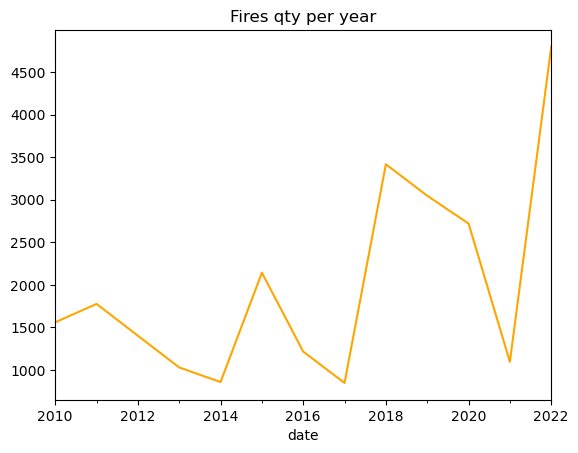

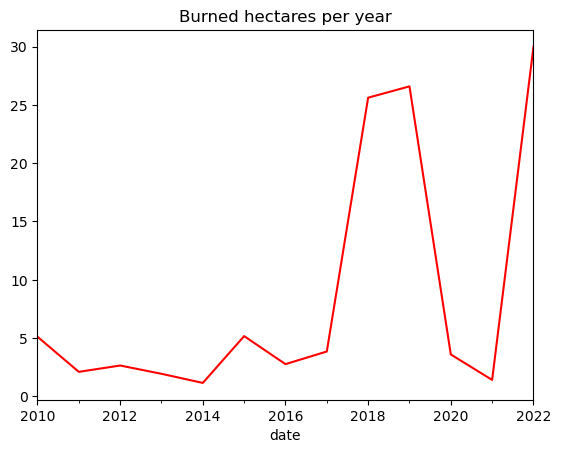

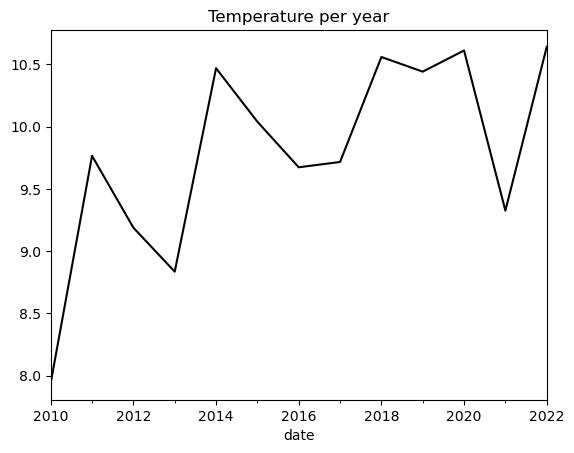

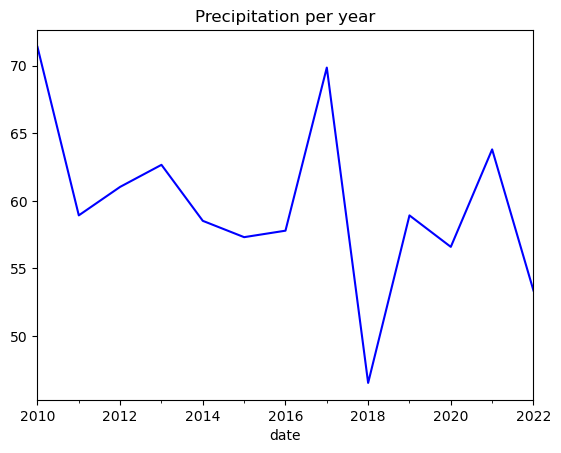

In [130]:
fires_lstm.fires_qty.resample('Y').sum().plot(title='Fires qty per year', color='orange') 
#plt.tight_layout()
plt.show()   

fires_lstm.burned_ha.resample('Y').mean().plot(title='Burned hectares per year', color='red') 
#plt.tight_layout()
plt.show()

fires_lstm.temperature.resample('Y').mean().plot(title='Temperature per year', color='black') 
#plt.tight_layout()
plt.show()

fires_lstm.precipitation.resample('Y').mean().plot(title='Precipitation per year', color='blue') 
#plt.tight_layout()
plt.show()

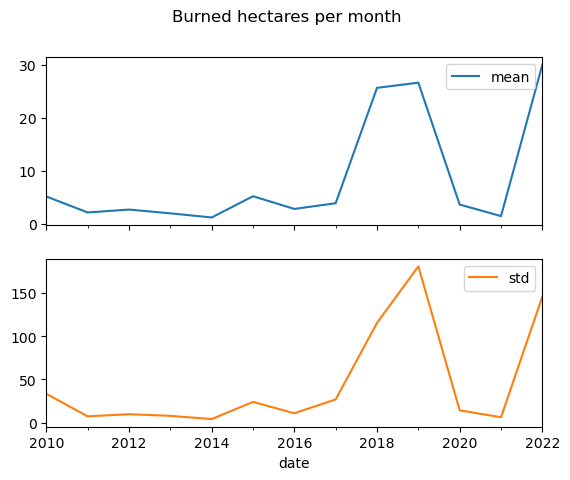

In [131]:
### Below I show mean and std of 'Global_intensity' resampled over day 

r = fires_lstm.burned_ha.resample('Y').agg(['mean', 'std'])
r.plot(subplots = True, title='Burned hectares per month')
plt.show()

In [132]:
fires_lstm.iloc[:, 1:-1]

,fires_qty,burned_ha,temperature,precipitation
date,,,,
2010-01-01,0,0.0,-2.76,59.74482
2010-02-01,0,0.0,0.13,60.20000
2010-03-01,3,0.8,3.81,51.50000
2010-04-01,7,4.3,8.79,23.80000
2010-05-01,0,0.0,10.65,129.90000
...,...,...,...,...
2022-08-01,595,351.0,20.23,48.90000
2022-09-01,180,64.0,13.37,100.00000
2022-10-01,50,13.0,12.52,49.70000


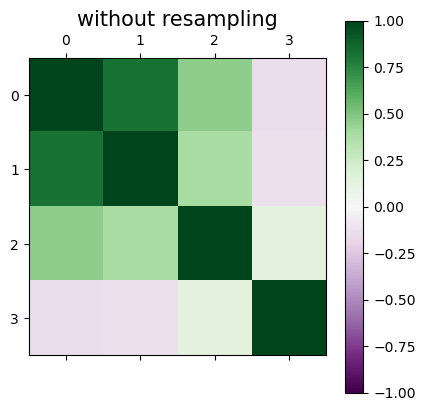

In [133]:
# Correlations among columns
plt.matshow(fires_lstm.iloc[:, 1:-1].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

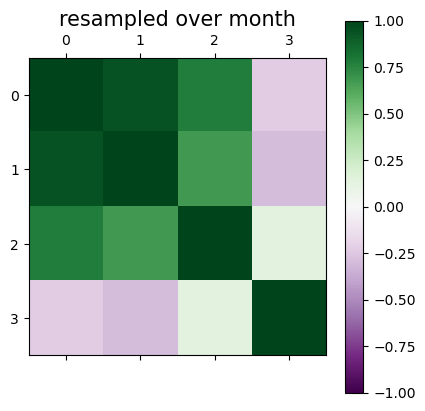

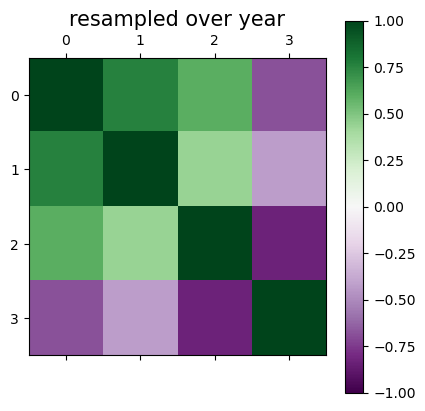

In [134]:
# Correlations of mean of features resampled over months


plt.matshow(fires_lstm.iloc[:, 1:-1].resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(fires_lstm.iloc[:, 1:-1].resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

In [135]:
# we rearrange the columns to make it easier to split them into train and test sets
# we leave cluster at the end because it will be the target

fires_lstm = fires_lstm[['fires_qty', 'burned_ha', 'state', 'temperature', 'precipitation', 'cluster']]
fires_lstm.head(1)

,fires_qty,burned_ha,state,temperature,precipitation,cluster
date,,,,,,
2010-01-01,0,0.0,Baden Wurttemberg,-2.76,59.74482,0


In [162]:
fires_lstm = fires_lstm.query('state != "Germany"')

In [163]:
features = fires_lstm.iloc[:, 2:-1]
display(features.head(1))
target = fires_lstm.iloc[:, -1:]
display(target.head(1))
display(target.info())

,state,temperature,precipitation
date,,,
2010-01-01,Baden Wurttemberg,-2.76,59.74482


,cluster
date,
2010-01-01,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2496 entries, 2010-01-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cluster  2496 non-null   int32
dtypes: int32(1)
memory usage: 29.2 KB


None

In [164]:
# we split the data into training, validation and test

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=444)

In [165]:
# we need to divide into numerical and categorical data

X_num_train =  X_train.select_dtypes(include = "number")
X_num_test = X_test.select_dtypes(include = "number")
X_cat_train = X_train.select_dtypes(exclude = "number")
X_cat_test = X_test.select_dtypes(exclude = "number")

In [166]:
# now we need to impute the missing values in the dataset  - we'll use the SimpleImputer class from the sklearn library

# we import necessary libraries
# from sklearn.impute import SimpleImputer

# we start with numeric features
num_imputer = SimpleImputer(strategy = 'mean')                 # first we initialize the imputer
num_imputer.fit(X_num_train)                                   # then we fit the imputer to the training data
X_num_train_imp = num_imputer.transform(X_num_train)           # and transform the training set
X_num_test_imp = num_imputer.transform(X_num_test)             # and transform the testing set

# now we do the same for the categorical features
cat_imputer = SimpleImputer(strategy = 'constant', fill_value = 'N_A')         # first we initialize the imputer
cat_imputer.fit(X_cat_train)                                             # then we fit the imputer to the training data
X_cat_train_imp = cat_imputer.transform(X_cat_train)                       # and transform the training set
X_cat_test_imp = cat_imputer.transform(X_cat_test)                         # and transform the testing set

In [167]:
# and now we need to use one hot encoder to transform the categorical data into numerical data

# first we initialize the encoder
cat_encoder = OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown = 'ignore') 
cat_encoder.fit(X_cat_train_imp)                                            # then we fit the encoder to the training data
X_cat_train_imp_hot = cat_encoder.transform(X_cat_train_imp)                # and transform the training set
X_cat_test_imp_hot = cat_encoder.transform(X_cat_test_imp)                  # and transform the testing set

In [168]:
# now we concatenate the numerical and categorical data

X_train_imp = pd.concat([X_num_train_imp, X_cat_train_imp_hot], axis = 1)
X_test_imp = pd.concat([X_num_test_imp, X_cat_test_imp_hot], axis = 1)

display(X_train_imp.head(1))
display(X_test_imp.head(1))

,temperature,precipitation,state_Bavaria,state_Berlin,state_Brandenburg,state_Bremen,state_Hamburg,state_Hessen,state_Lower Saxony,state_Mecklenburg-Vorpommern,state_Nordrhein-Westfalen,state_Rhineland-Palatinate,state_Saarland,state_Saxony,state_Saxony Anhalt,state_Schleswig-Holstein,state_Thuringia
date,,,,,,,,,,,,,,,,,
2019-01-01,0.98,79.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,temperature,precipitation,state_Bavaria,state_Berlin,state_Brandenburg,state_Bremen,state_Hamburg,state_Hessen,state_Lower Saxony,state_Mecklenburg-Vorpommern,state_Nordrhein-Westfalen,state_Rhineland-Palatinate,state_Saarland,state_Saxony,state_Saxony Anhalt,state_Schleswig-Holstein,state_Thuringia
date,,,,,,,,,,,,,,,,,
2019-03-01,6.38,51.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
# now we need to scale

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_imp)
X_test = scaler.transform(X_test_imp)

In [177]:
sequence_length = 12
num_features = 17

# Convert X_train to a NumPy array
X_train_array = X_train.values

# Calculate the number of samples (batch_size)
num_samples = X_train_array.shape[0]

# Calculate the number of sequences you can create
num_sequences = num_samples - sequence_length + 1

# Initialize an empty array to store the sequences
sequences = []

# Create sequences
for i in range(num_sequences):
    sequence = X_train_array[i:i+sequence_length, :]  # Extract a sequence of length sequence_length
    sequences.append(sequence)

# Convert the list of sequences to a NumPy array
X_train_reshaped = np.array(sequences)

In [178]:
# Convert X_train to a NumPy array
X_test_array = X_test.values

# Calculate the number of samples (batch_size)
num_samples = X_test_array.shape[0]

# Calculate the number of sequences you can create
num_sequences = num_samples - sequence_length + 1

# Initialize an empty array to store the sequences
sequences = []

# Create sequences
for i in range(num_sequences):
    sequence = X_test_array[i:i+sequence_length, :]  # Extract a sequence of length sequence_length
    sequences.append(sequence)

# Convert the list of sequences to a NumPy array
X_test_reshaped = np.array(sequences)

In [179]:
X_test_reshaped

array([[[-0.52377058, -0.22872598, -0.25066472, ..., -0.25514974,
         -0.26285891, -0.25737   ],
        [-1.03002787,  1.2067136 , -0.25066472, ..., -0.25514974,
         -0.26285891, -0.25737   ],
        [ 0.1682692 ,  0.04118574, -0.25066472, ..., -0.25514974,
         -0.26285891, -0.25737   ],
        ...,
        [ 1.51674046, -0.36674901, -0.25066472, ..., -0.25514974,
         -0.26285891, -0.25737   ],
        [-0.45410215, -1.30837284, -0.25066472, ..., -0.25514974,
         -0.26285891, -0.25737   ],
        [ 1.34798803, -0.60292176, -0.25066472, ..., -0.25514974,
         -0.26285891, -0.25737   ]],

       [[-1.03002787,  1.2067136 , -0.25066472, ..., -0.25514974,
         -0.26285891, -0.25737   ],
        [ 0.1682692 ,  0.04118574, -0.25066472, ..., -0.25514974,
         -0.26285891, -0.25737   ],
        [ 0.40669007, -0.50170487, -0.25066472, ..., -0.25514974,
         -0.26285891,  3.88545675],
        ...,
        [-0.45410215, -1.30837284, -0.25066472, ..., -

In [173]:
from tensorflow.keras.optimizers import Adam

In [180]:
# we reshape the data to make it compatible with the LSTM model
y_train = y_train[:X_train_reshaped.shape[0]]
y_test = y_test[:X_test_reshaped.shape[0]]

# Convert to NumPy arrays with integer data type
y_train = np.array(y_train, dtype=int)
y_test = np.array(y_test, dtype=int)

In [181]:
# we need to make sure that X and y have the same shape - they appear to be mismatched

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)
print(y_train.shape)
print(y_test.shape)

(1985, 12, 17)
(489, 12, 17)
(1985, 1)
(489, 1)


In [184]:
# Create the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=128, input_shape=(12, 17), return_sequences=True))
lstm_model.add(Dense(units=1, activation = 'sigmoid'))  

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

batch_size = 150
# Train the model
lstm_model.fit(X_train_reshaped, y_train, epochs=15, batch_size=batch_size, validation_data = (X_test_reshaped, y_test), verbose = 1, shuffle = False)

# Evaluate the model on the test set
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/15
14/14 [==============================] - 4s 82ms/step - loss: 0.6781 - accuracy: 0.5656 - val_loss: 0.6677 - val_accuracy: 0.5769
Epoch 2/15
14/14 [==============================] - 0s 26ms/step - loss: 0.6320 - accuracy: 0.6016 - val_loss: 0.6258 - val_accuracy: 0.5593
Epoch 3/15
14/14 [==============================] - 0s 25ms/step - loss: 0.5501 - accuracy: 0.5762 - val_loss: 0.5952 - val_accuracy: 0.5642
Epoch 4/15
14/14 [==============================] - 0s 26ms/step - loss: 0.5018 - accuracy: 0.6084 - val_loss: 0.5739 - val_accuracy: 0.6157
Epoch 5/15
14/14 [==============================] - 0s 27ms/step - loss: 0.4217 - accuracy: 0.6401 - val_loss: 0.5050 - val_accuracy: 0.6466
Epoch 6/15
14/14 [==============================] - 0s 23ms/step - loss: 0.3354 - accuracy: 0.6697 - val_loss: 0.3762 - val_accuracy: 0.6513
Epoch 7/15
14/14 [==============================] - 0s 24ms/step - loss: 0.2298 - accuracy: 0.6825 - val_loss: 0.2986 - val_accuracy: 0.6489
Epoch 8/15
14